In [3]:
# imports 
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets, model_selection, preprocessing, svm, metrics, decomposition
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
np.random.seed(0) # set random seed so everyone gets same results
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
final = pd.read_csv("VAERS_final.csv")
X = final[["AGE_YRS", "SEX", "OTHER_MEDS","HISTORY","ALLERGIES","VAX_MANU","VAX_DOSE_SERIES"]]
y = final['labels']

X["AGE_YRS"] = X["AGE_YRS"].replace(np.NaN, X["AGE_YRS"].mean()) #replacing missing age values with mean of the column to prevent data loss
# List of the column names with features that should be ordinal encoded
ordinal_features = ['SEX','VAX_MANU']

# Ordinal encode all of these features
ordinal = sklearn.preprocessing.OrdinalEncoder()
X[ordinal_features] = ordinal.fit_transform(X[ordinal_features])


<ipython-input-4-13ae72a4d0ea>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["AGE_YRS"] = X["AGE_YRS"].replace(np.NaN, X["AGE_YRS"].mean()) #replacing missing age values with mean of the column to prevent data loss
<ipython-input-4-13ae72a4d0ea>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[ordinal_features] = ordinal.fit_transform(X[ordinal_features])
C:\Users\gkong\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, shuffle=True)
ss = preprocessing.StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=5)

In [6]:
print(X_train.shape)
print(X_test.shape)

(27339, 7)
(6835, 7)


In [8]:
# scoring metric used here is recall
# cross_val_score takes care of splitting X and y into the 10 folds that's why we pass X and y entirely instead of X_train and y_train
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X, y, cv=10, scoring='recall')
print(scores)

[0.15492958 0.16700201 0.13581489 0.18209256 0.29003021 0.35850957
 0.36958711 0.33937563 0.32897384 0.34808853]


In [9]:
# define the parameter values that should be searched
# for python 2, k_range = range(1, 31)
knn = KNeighborsClassifier(n_neighbors=5)
k_range = (range(1, 50))
#param_grid = dict(n_neighbors=k_range)
params = {
    'n_neighbors': (k_range),
    'weights': ('uniform', 'distance')
}

In [10]:
# instantiate the grid
grid = GridSearchCV(knn, param_grid = params, cv=10, scoring="recall")

In [11]:
# fit the grid with data
grid.fit(X, y)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ('uniform', 'distance')},
             scoring='recall')

In [12]:
# examine the best model

print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.3615273716822587
{'n_neighbors': 1, 'weights': 'uniform'}
KNeighborsClassifier(n_neighbors=1)


In [13]:
# instantiate model with best parameters
knn = KNeighborsClassifier(n_neighbors=1, weights='uniform')

# fit with X and y, not X_train and y_train
# even if we use train/test split, we should train on X and y before making predictions on new data
# otherwise we throw away potential valuable data we can learn from
knn.fit(X, y)

y_pred=knn.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
knn_cv_score = cross_val_score(knn, X, y, cv=10, scoring='recall')

Accuracy: 0.7145574250182882
Recall: 0.025967413441955193


In [14]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print('\n')
print("=== All AUC Scores ===")
print(knn_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Knn: ", knn_cv_score.mean())

=== Confusion Matrix ===
[[4833   38]
 [1913   51]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.72      0.99      0.83      4871
           1       0.57      0.03      0.05      1964

    accuracy                           0.71      6835
   macro avg       0.64      0.51      0.44      6835
weighted avg       0.68      0.71      0.61      6835



=== All AUC Scores ===
[0.28370221 0.27665996 0.3028169  0.30080483 0.3897281  0.38066465
 0.42598187 0.3856999  0.42555332 0.44366197]


=== Mean AUC Score ===
Mean AUC Score - Knn:  0.3615273716822587


<Figure size 432x288 with 0 Axes>

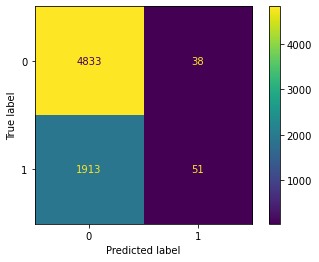

In [15]:
plt.figure()
metrics.plot_confusion_matrix(knn, X_test, y_test)
plt.show()